In [1]:
from asgardpy.analysis import AsgardpyAnalysis
from asgardpy.config import AsgardpyConfig

from gammapy.maps import Map
from gammapy.modeling.models import Models
from gammapy.modeling import Fit
from gammapy.estimators import FluxPointsEstimator
from gammapy.datasets import Datasets

import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
import logging

In [2]:
from asgardpy.data.dataset_3d import Dataset3DGeneration

In [3]:
log = logging.getLogger("test DL4 steps")

In [4]:
base_dir = "/fefs/aswg/workspace/chaitanya.priyadarshi/"
config_file = base_dir + "analyze_pg1553_full.yaml"
output_dir = base_dir + "real_data/AGN/PG1553/v09x/tailcut84/DL3/interp_irf_en_dep/no_tuning/geff_80/teff_80/20220511_dec931/joint_fit/"

In [5]:
config = AsgardpyConfig()

In [6]:
%%time
config_main = config.read(config_file)

CPU times: user 48.2 ms, sys: 5.91 ms, total: 54.1 ms
Wall time: 51.5 ms


In [7]:
for g in config_main.general:
    print(g)

('log', LogConfig(level='info', filename=None, filemode=None, format=None, datefmt=None))
('outdir', '/fefs/aswg/workspace/chaitanya.priyadarshi/real_data/AGN/PG1553/v09x/tailcut84/DL3/interp_irf_en_dep/no_tuning/geff_80/teff_80/20220511_dec931/joint_fit/')
('n_jobs', 1)
('steps', [<AnalysisStepEnum.datasets_3d: 'datasets-3d'>, <AnalysisStepEnum.datasets_1d: 'datasets-1d'>, <AnalysisStepEnum.fit: 'fit'>, <AnalysisStepEnum.flux_points: 'flux-points'>])
('overwrite', True)
('stacked_dataset', True)


# Steps mentioned in the main config file

In [8]:
config_main.general.steps

[<AnalysisStepEnum.datasets_3d: 'datasets-3d'>,
 <AnalysisStepEnum.datasets_1d: 'datasets-1d'>,
 <AnalysisStepEnum.fit: 'fit'>,
 <AnalysisStepEnum.flux_points: 'flux-points'>]

In [9]:
for c in config_main.target:
    print(c)

('source_name', 'PG1553+113')
('sky_position', SkyCoordConfig(frame=<FrameEnum.icrs: 'icrs'>, lon=<Angle 238.92934976 deg>, lat=<Angle 11.19010155 deg>))
('use_uniform_position', True)
('models_file', None)
('extended', False)
('components', SkyModelComponent(name='PG1553+113', type='SkyModel', spectral=SpectralModelConfig(model_name='LogParabola', type='LogParabolaSpectralModel', parameters=[ModelParams(name='amplitude', value=1e-05, unit='cm-2 s-1 TeV-1', error=1.5e-06, min=1e-13, max=0.01, frozen=False), ModelParams(name='reference', value=0.0015, unit='TeV', error=0.0, min=0.0001, max=100.0, frozen=True), ModelParams(name='alpha', value=1.5, unit='', error=0.1, min=0.5, max=5.0, frozen=False), ModelParams(name='beta', value=0.1, unit='', error=0.01, min=1e-06, max=1.0, frozen=False)], ebl_abs=EBLAbsorptionModel(model_name='dominguez', type='EBLAbsorptionNormSpectralModel', redshift=0.433, alpha_norm=1.0)), spatial=SpatialModelConfig(model_name=None, type=None, parameters=[ModelPara

# Datasets informations

In [10]:
for cc in config_main.dataset3d:
    print(cc)

('type', <ReductionTypeEnum.cube: '3d'>)
('instruments', [Dataset3DBaseConfig(name='Fermi-LAT', io=[InputConfig(type='lat', input_dir=PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola'), glob_pattern={'events': '*MkTime.fits*', 'edisp': '*eDRM.fits*', 'xml_model': '*out.xml', 'exposure': '*BinnedMap.fits*', 'psf': '*psf.fits*'}), InputConfig(type='lat-aux', input_dir=PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/diffuse_models'), glob_pattern={'diffuse': 'gll_iem_v07.fits*', 'iso': 'iso_P8R3_SOURCE_V3_*.txt'})], dataset_info=Dataset3DInfoConfig(name='Fermi-LAT', key=['FRONT', 'BACK'], map_selection=[<MapSelectionEnum.counts: 'counts'>, <MapSelectionEnum.exposure: 'exposure'>, <MapSelectionEnum.background: 'background'>, <MapSelectionEnum.psf: 'psf'>, <MapSelectionEnum.edisp: 'edisp'>], obs_time=TimeIntervalsConfig(format=<TimeFormatEnum.iso: 'iso'>, intervals=[TimeRangeConfig(start=<Time object: scale='utc' format='iso' value=2021-04-01 00:00:

In [11]:
for cc in config_main.dataset1d:
    print(cc)

('type', <ReductionTypeEnum.spectrum: '1d'>)
('instruments', [Dataset1DBaseConfig(name='LST-1', io=[InputConfig(type='lst-1', input_dir=PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/real_data/AGN/PG1553/v09x/tailcut84/DL3/interp_irf_en_dep/no_tuning/geff_80/teff_80/20220511_dec931'), glob_pattern={'dl3': '202*/dl3*fits'})], dataset_info=Dataset1DInfoConfig(name='LST-1', geom=GeomConfig(wcs=WcsConfig(skydir=SkyCoordConfig(frame=None, lon=None, lat=None), binsize=<Angle 0.02 deg>, final_frame=FinalFrameConfig(width=<Angle 5. deg>, height=<Angle 5. deg>), binsize_irf=<Angle 0.2 deg>), selection=SelectionConfig(offset_max=<Angle 2.5 deg>), axes=EnergyAxesConfig(energy=EnergyAxisConfig(min=<Quantity 10. GeV>, max=<Quantity 10. TeV>, nbins=5), energy_true=EnergyAxisConfig(min=<Quantity 10. GeV>, max=<Quantity 10. TeV>, nbins=5))), observation=ObservationsConfig(obs_ids=[], obs_file=None, obs_time=TimeIntervalsConfig(format=<TimeFormatEnum.iso: 'iso'>, intervals=[TimeRangeConfig(start

# DL4 step information

In [12]:
for cc in config_main.fit_params:
    print(cc)

('fit_range', EnergyRangeConfig(min=<Quantity 100. MeV>, max=<Quantity 1. TeV>))
('backend', <BackendEnum.minuit: 'minuit'>)
('optimize_opts', {})
('covariance_opts', {})
('confidence_opts', {})
('store_trace', True)


In [13]:
for cc in config_main.flux_points_params:
    print(cc)

('parameters', {'selection_optional': 'all'})


In [14]:
%%time
analysis = AsgardpyAnalysis(config_main)

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}


CPU times: user 1.46 ms, sys: 529 µs, total: 1.98 ms
Wall time: 1.75 ms


In [15]:
analysis

# Prepare the dataset

In [16]:
instruments_list_3d = config_main.dataset3d.instruments
print(len(instruments_list_3d), "number of 3D dataset information provided")

config_3d_dataset = instruments_list_3d[0]
print(f"Instrument selected is {config_3d_dataset.name}")

1 number of 3D dataset information provided
Instrument selected is Fermi-LAT


In [17]:
instruments_list_1d = config_main.dataset1d.instruments
print(len(instruments_list_1d), "number of 1D dataset information provided")

config_1d_dataset = instruments_list_1d[0]
print(f"Instrument selected is {config_1d_dataset.name}")

1 number of 1D dataset information provided
Instrument selected is LST-1


In [18]:
key_names = config_3d_dataset.dataset_info.key
print(f"The list of different keys or modes of observations for the selected instrument are {key_names}")

The list of different keys or modes of observations for the selected instrument are ['FRONT', 'BACK']


# Run each Dataset nD Generation step

In [19]:
%%time
analysis.run(["datasets-3d"])

1 number of 3D Datasets given
The different keys used: ['FRONT', 'BACK']
The list of DL3 event files for LAT selected: [PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola/PG_1553+113_LAT_Analysis_BACK_MkTime.fits.gz'), PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola/PG_1553+113_LAT_Analysis_FRONT_MkTime.fits.gz')]
The list of Detector Response Matrix files for LAT selected: [PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola/PG_1553+113_LAT_Analysis_BACK_LogParabola_eDRM.fits.gz'), PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola/PG_1553+113_LAT_Analysis_FRONT_LogParabola_eDRM.fits.gz')]
The list of XML files for LAT selected: [PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola/PG_1553+113_LogParabola_LAT_Analysis_out.xml')]
The list of Exposure Map files for LAT selected: [PosixPath('/fefs/aswg/wor

Other method of creating safe mask


The list of DL3 event files for LAT selected: [PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola/PG_1553+113_LAT_Analysis_BACK_MkTime.fits.gz'), PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola/PG_1553+113_LAT_Analysis_FRONT_MkTime.fits.gz')]
The list of Detector Response Matrix files for LAT selected: [PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola/PG_1553+113_LAT_Analysis_BACK_LogParabola_eDRM.fits.gz'), PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola/PG_1553+113_LAT_Analysis_FRONT_LogParabola_eDRM.fits.gz')]
The list of XML files for LAT selected: [PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola/PG_1553+113_LogParabola_LAT_Analysis_out.xml')]
The list of Exposure Map files for LAT selected: [PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola/PG_1553+11

Using the exclusion mask to create a safe mask


Using the background region from config for exclusion mask


Other method of creating safe mask


Analysis Step datasets-3d completed


Using the exclusion mask to create a safe mask
Dataset names in the target model are: ['Fermi-LAT_FRONT', 'Fermi-LAT_BACK']
Included for the target source is dataset of name: Fermi-LAT_FRONT
Included for the target source is dataset of name: Fermi-LAT_BACK
CPU times: user 4.71 s, sys: 2.97 s, total: 7.69 s
Wall time: 8 s


## Display some results

In [20]:
print(analysis.datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : Fermi-LAT_FRONT
  Instrument : 
  Models     : 

Dataset 1: 

  Type       : MapDataset
  Name       : Fermi-LAT_BACK
  Instrument : 
  Models     : 




In [21]:
print(analysis.final_model)

[SkyModel(spatial_model=<gammapy.modeling.models.spatial.PointSpatialModel object at 0x7f4845785070>, spectral_model=<gammapy.modeling.models.spectral.CompoundSpectralModel object at 0x7f4845792460>)temporal_model=None), SkyModel(spatial_model=<gammapy.modeling.models.spatial.PointSpatialModel object at 0x7f48621184f0>, spectral_model=<gammapy.modeling.models.spectral.PowerLawSpectralModel object at 0x7f4862088220>)temporal_model=None), SkyModel(spatial_model=<gammapy.modeling.models.spatial.PointSpatialModel object at 0x7f48613554c0>, spectral_model=<gammapy.modeling.models.spectral.LogParabolaSpectralModel object at 0x7f48620d1ca0>)temporal_model=None), SkyModel(spatial_model=<gammapy.modeling.models.spatial.PointSpatialModel object at 0x7f4845773d30>, spectral_model=<gammapy.modeling.models.spectral.LogParabolaSpectralModel object at 0x7f48457731c0>)temporal_model=None), SkyModel(spatial_model=<gammapy.modeling.models.spatial.PointSpatialModel object at 0x7f4845773100>, spectral_mod

In [22]:
for m in analysis.final_model:
    print(m)

SkyModel

  Name                      : PG1553+113
  Datasets names            : ['Fermi-LAT_FRONT', 'Fermi-LAT_BACK']
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.00e-05   +/- 1.5e-06 1 / (cm2 s TeV)
    reference             (frozen):      0.002       TeV         
    alpha                         :      1.500   +/-    0.10             
    beta                          :      0.100   +/-    0.01             
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.433                   
    lon_0                 (frozen):      0.382       rad         
    lat_0                 (frozen):      0.767       rad         


SkyModel

  Name                      : 4FGL J1541.7+1413
  Datasets names            : ['Fermi-LAT_FRONT', 'Fermi-LAT_BACK']
  Spectral model type       : PowerLawSpectralModel
 

In [23]:
for i, en_range in enumerate(analysis.spectral_energy_ranges):
    print(f"The spectral energy range to be used for dataset {i+1} is {en_range}")

The spectral energy range to be used for dataset 1 is [1.00000000e-04 3.16227766e-04 1.00000000e-03 3.16227766e-03
 1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00] TeV
The spectral energy range to be used for dataset 2 is [1.00000000e-04 3.16227766e-04 1.00000000e-03 3.16227766e-03
 1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00] TeV


In [24]:
print(analysis.dataset_name_list)

['Fermi-LAT_FRONT', 'Fermi-LAT_BACK']


In [25]:
%%time
analysis.run(["datasets-1d"])

1 number of 1D Datasets given
The list of DL3 files for LST-1 selected: [PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/real_data/AGN/PG1553/v09x/tailcut84/DL3/interp_irf_en_dep/no_tuning/geff_80/teff_80/20220511_dec931/20210407/dl3_LST-1.Run04333.fits'), PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/real_data/AGN/PG1553/v09x/tailcut84/DL3/interp_irf_en_dep/no_tuning/geff_80/teff_80/20220511_dec931/20210407/dl3_LST-1.Run04334.fits'), PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/real_data/AGN/PG1553/v09x/tailcut84/DL3/interp_irf_en_dep/no_tuning/geff_80/teff_80/20220511_dec931/20210407/dl3_LST-1.Run04335.fits'), PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/real_data/AGN/PG1553/v09x/tailcut84/DL3/interp_irf_en_dep/no_tuning/geff_80/teff_80/20220511_dec931/20210407/dl3_LST-1.Run04336.fits'), PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/real_data/AGN/PG1553/v09x/tailcut84/DL3/interp_irf_en_dep/no_tuning/geff_80/teff_80/20220511_dec931/20210408/dl3_

Observation ID list selected: [4333 4334 4335 4336 4343 4344 4363 4364 4365 4366 4367 4368 4514 4515
 4652 4653 4654 4902 4903 4904 4905 4930 4940 4941 4942 4943 7153 7154
 8059 8060 8061 8062 8063 8064 8377 8378 8379 8424 8425]
Observations selected: 39 out of 39.
Analysis Step datasets-1d completed


SpectrumDatasetOnOff
--------------------

  Name                            : LST-1 

  Total counts                    : 1653090 
  Total background counts         : 1634543.00
  Total excess counts             : 18547.00

  Predicted counts                : 1643816.50
  Predicted background counts     : 1643816.50
  Predicted excess counts         : nan

  Exposure min                    : 5.34e+07 m2 s
  Exposure max                    : 1.14e+10 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 10 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 183.81

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1634543 
  Acceptance                      : 15 
  Acceptance off                  : 15 

Before enlisting from a 1D dataset ['Fermi-LAT_FRONT', 'Fermi-LAT_BACK']
After enlisting from a 1D dataset ['Fermi-LAT_FRONT', 'Fe

## Display the results

In [26]:
print(analysis.datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : Fermi-LAT_FRONT
  Instrument : 
  Models     : 

Dataset 1: 

  Type       : MapDataset
  Name       : Fermi-LAT_BACK
  Instrument : 
  Models     : 

Dataset 2: 

  Type       : SpectrumDatasetOnOff
  Name       : LST-1
  Instrument : 
  Models     : 




In [27]:
for d in analysis.datasets:
    print(d)

MapDataset
----------

  Name                            : Fermi-LAT_FRONT 

  Total counts                    : 507 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.13e+08 cm2 s
  Exposure max                    : 7.65e+08 cm2 s

  Number of total bins            : 815121 
  Number of fit bins              : 745093 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


MapDataset
----------

  Name                            : Fermi-LAT_BACK 

  Total counts                    : 458 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted

In [28]:
for m in analysis.final_model:
    print(m)

SkyModel

  Name                      : PG1553+113
  Datasets names            : ['Fermi-LAT_FRONT', 'Fermi-LAT_BACK']
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.00e-05   +/- 1.5e-06 1 / (cm2 s TeV)
    reference             (frozen):      0.002       TeV         
    alpha                         :      1.500   +/-    0.10             
    beta                          :      0.100   +/-    0.01             
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.433                   
    lon_0                 (frozen):      0.382       rad         
    lat_0                 (frozen):      0.767       rad         


SkyModel

  Name                      : 4FGL J1541.7+1413
  Datasets names            : ['Fermi-LAT_FRONT', 'Fermi-LAT_BACK']
  Spectral model type       : PowerLawSpectralModel
 

In [29]:
for i, en_range in enumerate(analysis.spectral_energy_ranges):
    print(f"The spectral energy range to be used for dataset {i+1} is {en_range}")

The spectral energy range to be used for dataset 1 is [1.00000000e-04 3.16227766e-04 1.00000000e-03 3.16227766e-03
 1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00] TeV
The spectral energy range to be used for dataset 2 is [1.00000000e-04 3.16227766e-04 1.00000000e-03 3.16227766e-03
 1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00] TeV
The spectral energy range to be used for dataset 3 is [ 0.01        0.01584893  0.02511886  0.03981072  0.06309573  0.1
  0.15848932  0.25118864  0.39810717  0.63095734  1.          1.58489319
  2.51188643  3.98107171  6.30957344 10.        ] TeV


In [30]:
print(analysis.dataset_name_list)

['Fermi-LAT_FRONT', 'Fermi-LAT_BACK', 'LST-1']


# Preparing the Datasets for DL4 steps

In [31]:
analysis.final_model = Models(analysis.final_model)

In [32]:
# Only updating the target source model with names of all datasets
analysis.final_model[config_main.target.source_name].datasets_names = analysis.dataset_name_list

In [33]:
print(analysis.final_model[config_main.target.source_name])

SkyModel

  Name                      : PG1553+113
  Datasets names            : ['Fermi-LAT_FRONT', 'Fermi-LAT_BACK', 'LST-1']
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.00e-05   +/- 1.5e-06 1 / (cm2 s TeV)
    reference             (frozen):      0.002       TeV         
    alpha                         :      1.500   +/-    0.10             
    beta                          :      0.100   +/-    0.01             
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.433                   
    lon_0                 (frozen):      0.382       rad         
    lat_0                 (frozen):      0.767       rad         




## Assigning the models to all the datasets

In [34]:
analysis.datasets.models = analysis.final_model

In [35]:
print(analysis.datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : Fermi-LAT_FRONT
  Instrument : 
  Models     : ['PG1553+113', '4FGL J1541.7+1413', '4FGL J1546.0+0819', '4FGL J1548.3+1456', '4FGL J1550.7+0528', '4FGL J1603.8+1104', '4FGL J1607.0+1550', '4FGL J1608.7+1029', '4FGL J1612.1+1407', 'diffuse-iem', 'fermi-diffuse-iso-FRONT']

Dataset 1: 

  Type       : MapDataset
  Name       : Fermi-LAT_BACK
  Instrument : 
  Models     : ['PG1553+113', '4FGL J1541.7+1413', '4FGL J1546.0+0819', '4FGL J1548.3+1456', '4FGL J1550.7+0528', '4FGL J1603.8+1104', '4FGL J1607.0+1550', '4FGL J1608.7+1029', '4FGL J1612.1+1407', 'diffuse-iem', 'fermi-diffuse-iso-BACK']

Dataset 2: 

  Type       : SpectrumDatasetOnOff
  Name       : LST-1
  Instrument : 
  Models     : ['PG1553+113']




In [36]:
%%time
for d in analysis.datasets:
    print(d)      

MapDataset
----------

  Name                            : Fermi-LAT_FRONT 

  Total counts                    : 507 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : 395.83
  Predicted background counts     : nan
  Predicted excess counts         : 395.83

  Exposure min                    : 2.13e+08 cm2 s
  Exposure max                    : 7.65e+08 cm2 s

  Number of total bins            : 815121 
  Number of fit bins              : 745093 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 7167.67

  Number of models                : 11 
  Number of parameters            : 62
  Number of free parameters       : 19

  Component 0: SkyModel
  
    Name                      : PG1553+113
    Datasets names            : ['Fermi-LAT_FRONT', 'Fermi-LAT_BACK', 'LST-1']
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type 

MapDataset
----------

  Name                            : Fermi-LAT_BACK 

  Total counts                    : 458 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : 372.87
  Predicted background counts     : nan
  Predicted excess counts         : 372.87

  Exposure min                    : 1.92e+08 cm2 s
  Exposure max                    : 6.90e+08 cm2 s

  Number of total bins            : 815121 
  Number of fit bins              : 745093 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 6563.82

  Number of models                : 11 
  Number of parameters            : 62
  Number of free parameters       : 19

  Component 0: SkyModel
  
    Name                      : PG1553+113
    Datasets names            : ['Fermi-LAT_FRONT', 'Fermi-LAT_BACK', 'LST-1']
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type  

# Run the Fit step

In [37]:
fit_check = Fit()

In [38]:
%%time
fit_result_full = fit_check.run(datasets=analysis.datasets)

CPU times: user 6min 48s, sys: 15.1 s, total: 7min 3s
Wall time: 7min 3s


In [39]:
print(fit_result_full)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 1618
	total stat : 13589.51

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [40]:
instruments_names = []
for ins in config_main.dataset3d.instruments:
    instruments_names.append(ins.name)
for ins in config_main.dataset1d.instruments:
    instruments_names.append(ins.name)
print(instruments_names)

['Fermi-LAT', 'LST-1']


In [41]:
names = analysis.datasets.names
print(names)

['Fermi-LAT_FRONT', 'Fermi-LAT_BACK', 'LST-1']


In [42]:
for n in instruments_names:
    print(n)
    dataset_list = [nn for nn in names if n in nn]
    print(dataset_list)

Fermi-LAT
['Fermi-LAT_FRONT', 'Fermi-LAT_BACK']
LST-1
['LST-1']


In [43]:
fermi_dataset = Datasets(analysis.datasets[:2])
print(fermi_dataset)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : Fermi-LAT_FRONT
  Instrument : 
  Models     : ['PG1553+113', '4FGL J1541.7+1413', '4FGL J1546.0+0819', '4FGL J1548.3+1456', '4FGL J1550.7+0528', '4FGL J1603.8+1104', '4FGL J1607.0+1550', '4FGL J1608.7+1029', '4FGL J1612.1+1407', 'diffuse-iem', 'fermi-diffuse-iso-FRONT']

Dataset 1: 

  Type       : MapDataset
  Name       : Fermi-LAT_BACK
  Instrument : 
  Models     : ['PG1553+113', '4FGL J1541.7+1413', '4FGL J1546.0+0819', '4FGL J1548.3+1456', '4FGL J1550.7+0528', '4FGL J1603.8+1104', '4FGL J1607.0+1550', '4FGL J1608.7+1029', '4FGL J1612.1+1407', 'diffuse-iem', 'fermi-diffuse-iso-BACK']




# Run the Flux Points Estimator step

In [44]:
fpe_fermi = FluxPointsEstimator(
    energy_edges=analysis.spectral_energy_ranges[0],
    source=config_main.target.source_name,
    **config_main.flux_points_params.parameters
)

In [45]:
%%time
fermi_fp = fpe_fermi.run(datasets=fermi_dataset)

CPU times: user 5min 52s, sys: 3min 20s, total: 9min 12s
Wall time: 9min 12s


In [46]:
print(fermi_fp)

FluxPoints
----------

  geom                   : RegionGeom
  axes                   : ['lon', 'lat', 'energy']
  shape                  : (1, 1, 8)
  quantities             : ['norm', 'norm_err', 'norm_errn', 'norm_errp', 'norm_ul', 'ts', 'npred', 'npred_excess', 'stat', 'counts', 'success', 'stat_scan']
  ref. model             : compound
  n_sigma                : 1
  n_sigma_ul             : 2
  sqrt_ts_threshold_ul   : 2
  sed type init          : likelihood



In [47]:
fermi_fpt = fermi_fp.to_table(sed_type="e2dnde", formatted=True)
fermi_fpt

e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
MeV,MeV,MeV,MeV2 / (cm2 s TeV),MeV2 / (cm2 s TeV),MeV2 / (cm2 s TeV),MeV2 / (cm2 s TeV),MeV2 / (cm2 s TeV),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[2],float32[2],float64,bool,float64[2],bool,float64[11],float64[11]
212.793,150.356,301.159,3.096e-08,1.990e-05,1.276e+00,nan,4.550e+00,-0.000,0.000,214.71308875590267 .. 192.3209576764188,3.1178555e-08 .. 2.8786625e-08,5457.789,True,225.0 .. 192.0,True,0.200 .. 5.000,5458.177 .. 5471.420
537.267,301.159,958.485,1.022e+01,3.553e+00,3.813e+00,3.290e+00,1.836e+01,18.277,4.275,196.6649605275738 .. 193.2473238052555,9.817992 .. 9.80448,5271.123,False,186.0 .. 183.0,True,0.200 .. 5.000,5281.695 .. 5301.572
1709.938,958.485,3050.531,2.348e+01,6.142e+00,6.631e+00,5.668e+00,3.775e+01,73.126,8.551,59.70558795424165 .. 63.97069322069821,8.766532 .. 9.121659,2105.077,False,73.0 .. 63.0,True,0.200 .. 5.000,2128.229 .. 2164.693
5442.150,3050.531,9708.801,2.968e+01,1.139e+01,1.286e+01,1.001e+01,5.849e+01,59.867,7.737,16.056854940940912 .. 16.33893995674057,3.5554254 .. 3.6271918,602.211,False,19.0 .. 17.0,True,0.200 .. 5.000,610.442 .. 651.077
17320.508,9708.801,30899.800,1.276e+01,1.277e+01,1.734e+01,8.917e+00,5.752e+01,11.772,3.431,3.690291723141092 .. 3.2605566644856063,0.5117364 .. 0.4910113,77.184,False,3.0 .. 1.0,True,0.200 .. 5.000,77.261 .. 106.640
55125.267,30899.800,98343.520,3.627e+01,3.691e+01,5.016e+01,2.580e+01,1.658e+02,6.180,2.486,1.2463419714739365 .. 0.945482840405175,0.50703174 .. 0.47475967,63.606,False,1.0 .. 2.0,True,0.200 .. 5.000,65.014 .. 68.886
175444.922,98343.520,312993.888,1.696e-05,5.806e-02,5.020e+01,nan,2.008e+02,-0.000,0.000,0.1700174810333476 .. 0.05973927826470722,8.978955e-08 .. 7.910755e-08,0.460,True,0.0 .. 0.0,True,0.200 .. 5.000,0.514 .. 1.828
558381.346,312993.888,996152.768,3.428e-07,8.815e-03,5.723e+01,nan,2.289e+02,-0.000,0.000,0.05192125142578285 .. 0.014480622985487962,1.6469521e-09 .. 1.3481619e-09,0.133,True,0.0 .. 0.0,True,0.200 .. 5.000,0.134 .. 0.157


(1e-15, 1e-08)

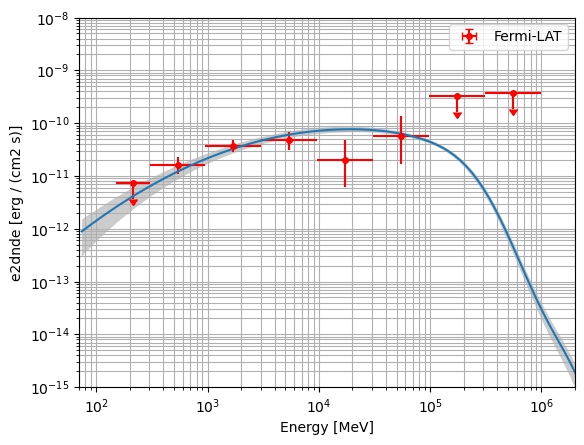

In [48]:
fermi_fp.plot(sed_type="e2dnde", color="red", label="Fermi-LAT")
analysis.datasets[0].models[config_main.target.source_name].spectral_model.plot(
    sed_type="e2dnde", energy_bounds=[70 * u.MeV,10 * u.TeV]
)
analysis.datasets[0].models[config_main.target.source_name].spectral_model.plot_error(
    sed_type="e2dnde", energy_bounds=[70 * u.MeV,10 * u.TeV]
)

plt.grid(which="both")
plt.legend()
plt.xlim(70, 2e6)
plt.ylim(1e-15, 1e-8)

In [49]:
fpe_lst = FluxPointsEstimator(
    energy_edges=analysis.spectral_energy_ranges[-1],
    source=config_main.target.source_name,
    **config_main.flux_points_params.parameters
)

In [50]:
%%time
lst_fp = fpe_lst.run(datasets=[analysis.datasets[-1]])

CPU times: user 11.1 s, sys: 121 ms, total: 11.3 s
Wall time: 11.3 s


In [51]:
print(lst_fp)

FluxPoints
----------

  geom                   : RegionGeom
  axes                   : ['lon', 'lat', 'energy']
  shape                  : (1, 1, 15)
  quantities             : ['norm', 'norm_err', 'norm_errn', 'norm_errp', 'norm_ul', 'ts', 'npred', 'npred_excess', 'stat', 'counts', 'success', 'stat_scan']
  ref. model             : compound
  n_sigma                : 1
  n_sigma_ul             : 2
  sqrt_ts_threshold_ul   : 2
  sed type init          : likelihood



In [52]:
lst_fpt = lst_fp.to_table(sed_type="e2dnde", formatted=True)
lst_fpt

e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,bool,float64[1],bool,float64[11],float64[11]
0.013,0.010,0.016,1.498e-11,1.498e-11,2.033e-11,1.208e-11,6.747e-11,1.386,1.177,0.9999548368256475,0.9999548,0.000,True,1.0,True,0.200 .. 5.000,0.195 .. 23.544
0.020,0.016,0.025,2.488e-11,3.697e-11,3.707e-11,nan,9.872e-11,0.439,0.663,39037.16305069008,187.32053,0.000,True,39036.0,True,0.200 .. 5.000,0.164 .. 33.301
0.032,0.025,0.040,3.961e-11,1.893e-11,1.883e-11,1.883e-11,7.728e-11,4.423,2.103,494893.01243605657,2090.025,0.000,False,494893.0,True,0.200 .. 5.000,2.611 .. 101.531
0.050,0.040,0.063,3.982e-11,9.024e-12,9.005e-12,9.005e-12,5.782e-11,19.544,4.421,569182.6705481377,4708.3354,0.000,False,569182.0,True,0.200 .. 5.000,12.385 .. 328.265
0.079,0.063,0.100,3.916e-11,6.084e-12,6.065e-12,6.065e-12,5.129e-11,41.696,6.457,363382.018158847,5484.036,0.000,False,363382.0,True,0.200 .. 5.000,29.028 .. 411.072
0.126,0.100,0.158,2.385e-11,3.431e-12,3.430e-12,3.430e-12,3.071e-11,48.342,6.953,139167.0097672276,3644.0193,0.000,False,139167.0,True,0.200 .. 5.000,32.123 .. 632.839
0.200,0.158,0.251,1.049e-11,1.567e-12,1.567e-12,1.566e-12,1.362e-11,44.802,6.693,36053.35579329948,1775.6941,0.000,False,36053.0,True,0.200 .. 5.000,28.341 .. 753.795
0.316,0.251,0.398,3.032e-12,6.376e-13,6.377e-13,6.375e-13,4.307e-12,22.617,4.756,8369.00002787598,604.00006,0.000,False,8369.0,True,0.200 .. 5.000,14.473 .. 356.890


(1e-15, 1e-08)

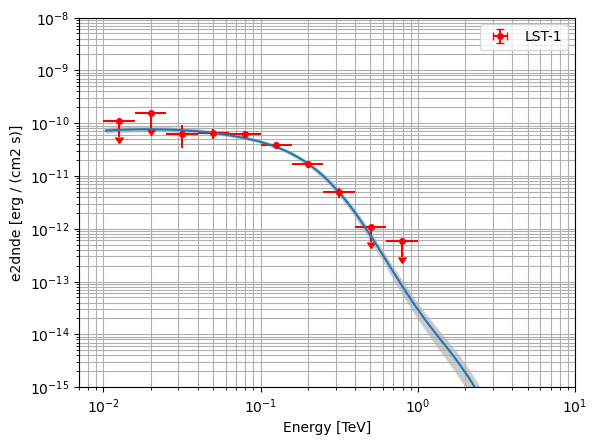

In [53]:
lst_fp.plot(sed_type="e2dnde", color="red", label="LST-1")
analysis.datasets[-1].models[0].spectral_model.plot(
    sed_type="e2dnde", energy_bounds=[10 * u.GeV, 10 * u.TeV]
)
analysis.datasets[-1].models[0].spectral_model.plot_error(
    sed_type="e2dnde", energy_bounds=[10 * u.GeV, 10 * u.TeV]
)

plt.grid(which="both")
plt.legend()
plt.xlim(0.007, 10)
plt.ylim(1e-15, 1e-8)

# Final SED plot with all instruments

(1e-15, 1e-08)

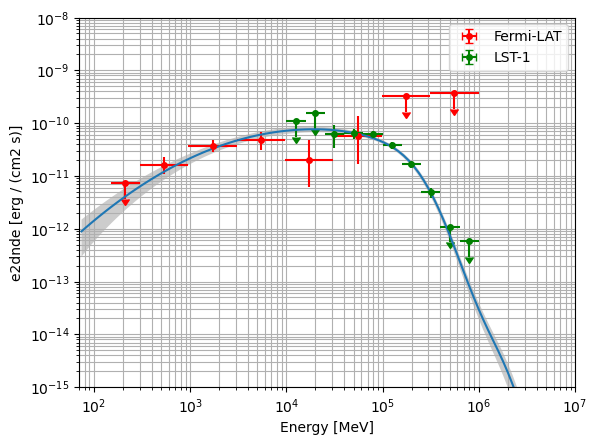

In [54]:
fermi_fp.plot(sed_type="e2dnde", color="red", label="Fermi-LAT")
lst_fp.plot(sed_type="e2dnde", color="green", label="LST-1")

analysis.datasets[-1].models[0].spectral_model.plot(
    sed_type="e2dnde", energy_bounds=[70 * u.MeV, 10 * u.TeV]
)
analysis.datasets[-1].models[0].spectral_model.plot_error(
    sed_type="e2dnde", energy_bounds=[70 * u.MeV, 10 * u.TeV]
)

plt.grid(which="both")
plt.legend()
plt.xlim(70, 1e7)
plt.ylim(1e-15, 1e-8)